### **1. Define a model**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

x_size = 28

def create_model():
  input_tensor = Input(shape=(x_size, x_size))
  x = Flatten()(input_tensor)
  x = Dense(100, activation='relu')(x)
  x = Dense(30, activation='relu')(x)
  output = Dense(10, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=output)
  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


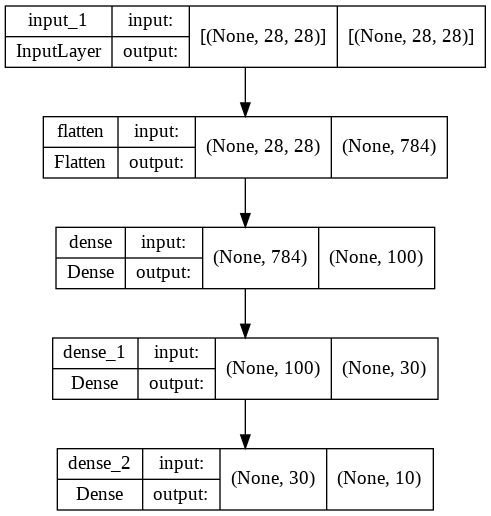

In [2]:
from tensorflow.keras.utils import plot_model

model = create_model()
model.summary()
plot_model(model, show_shapes=True)

### **2. Preprocess the data**

In [3]:
def data_preprocessing(x, y):
  x = np.array(x/255.0, dtype=np.float32)
  y = np.array(y, dtype=np.float32)
  return x, y

def data_one_hot_ecording(x, y):
  x, y = data_preprocessing(x, y)
  y_ohe = to_categorical(y)
  return x, y_ohe

def get_train_valid_test_set(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42):
  train_x, train_y_ohe = data_one_hot_ecording(train_x, train_y)
  test_x, test_y_ohe = data_one_hot_ecording(test_x, test_y)
  tr_x, val_x, tr_y_ohe, val_y_ohe = train_test_split(train_x, train_y_ohe, test_size=valid_size, random_state=random_state)
  return (tr_x, tr_y_ohe), (val_x, val_y_ohe), (test_x, test_y_ohe)

### **3. Load and split the dataset**

In [4]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(tr_x, tr_y_ohe), (val_x, val_y_ohe), (test_x, test_y_ohe) = \
get_train_valid_test_set(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42)
print(tr_x.shape, tr_y_ohe.shape, val_x.shape, val_y_ohe.shape, test_x.shape, test_y_ohe.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(51000, 28, 28) (51000, 10) (9000, 28, 28) (9000, 10) (10000, 28, 28) (10000, 10)


### **4. Compile the model**

In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### **5. Usage of callbacks**

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

cb_mcp = ModelCheckpoint(filepath='/content/save/weights.{epoch:02d}-{val_loss:.2f}.hdf5/', 
                         monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=0)
cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.2, verbose=1)
cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=16, verbose=1)

### **6. Train the model**

In [7]:
history = model.fit(x=tr_x, y=tr_y_ohe, validation_data=(val_x, val_y_ohe), batch_size=128, epochs=30, callbacks=[cb_mcp, cb_rlr, cb_esp])

Epoch 1/30
399/399 [==============================] - 5s 4ms/step - loss: 0.6043 - accuracy: 0.7938 - val_loss: 0.4586 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4166 - accuracy: 0.8547 - val_loss: 0.4128 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3760 - accuracy: 0.8663 - val_loss: 0.4109 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3511 - accuracy: 0.8738 - val_loss: 0.3735 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3306 - accuracy: 0.8801 - val_loss: 0.3658 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3150 - accuracy: 0.8845 - val_loss: 0.3910 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - lo

### **7. Load pre-trained weight**

In [8]:
model_cb = create_model()
model_cb.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_cb.load_weights('/content/save/weights.18-0.32.hdf5/')
pre_trained_loss, pre_trained_acc = model_cb.evaluate(val_x, val_y_ohe)
print(f'pre-trained accuracy : {(pre_trained_acc*100)}%')

282/282 [==============================] - 2s 4ms/step - loss: 0.3212 - accuracy: 0.8884
pre-trained accuracy : 88.84444236755371%


### **8. Visualize the result**

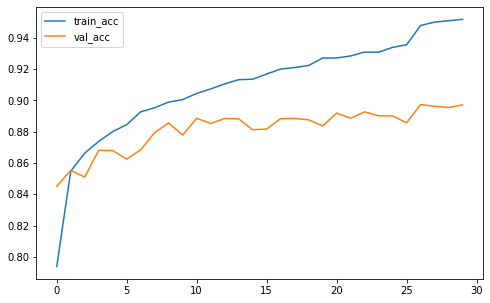

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

### **9. Evaluate accuracy**

In [10]:
test_loss, test_acc = model.evaluate(test_x, test_y_ohe)
print(f'test accuracy : {test_acc}%')

313/313 [==============================] - 1s 4ms/step - loss: 0.3604 - accuracy: 0.8906
test accuracy : 0.8906000256538391%


### **10. Make prediction**

In [11]:
pred_array = model.predict(test_x)
pred_array

array([[5.8867577e-10, 1.1144687e-10, 1.2769967e-10, ..., 8.8511495e-04,
        2.9013368e-08, 9.9911314e-01],
       [3.3849145e-05, 2.3710248e-12, 9.9741447e-01, ..., 1.0494652e-14,
        3.1844100e-12, 1.1759583e-16],
       [8.1760466e-13, 1.0000000e+00, 2.1582469e-12, ..., 8.2379513e-18,
        3.2660998e-17, 2.6361190e-21],
       ...,
       [7.3001183e-07, 5.1335533e-16, 3.2738699e-05, ..., 1.6742399e-11,
        9.9996483e-01, 2.5131142e-16],
       [1.4239439e-10, 1.0000000e+00, 1.0249927e-10, ..., 1.1192582e-13,
        2.4933251e-13, 2.0722794e-15],
       [1.6330054e-08, 6.6470264e-08, 5.5478471e-05, ..., 2.8260404e-04,
        2.1942265e-06, 1.0074558e-08]], dtype=float32)

In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
pred_label = np.argmax(pred_array[0])
print('predicted class value :', class_names[pred_label])

predicted class value : Ankle boot


In [13]:
def plot_image(i):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_x[i], cmap='gray')
  pred_label = np.argmax(pred_array[i])
  if pred_label == test_y[i]:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% / ({})".format(class_names[pred_label],
                                np.max(pred_array[i])*100,
                                class_names[test_y[i]]),
                                fontsize=12,
                                color=color)

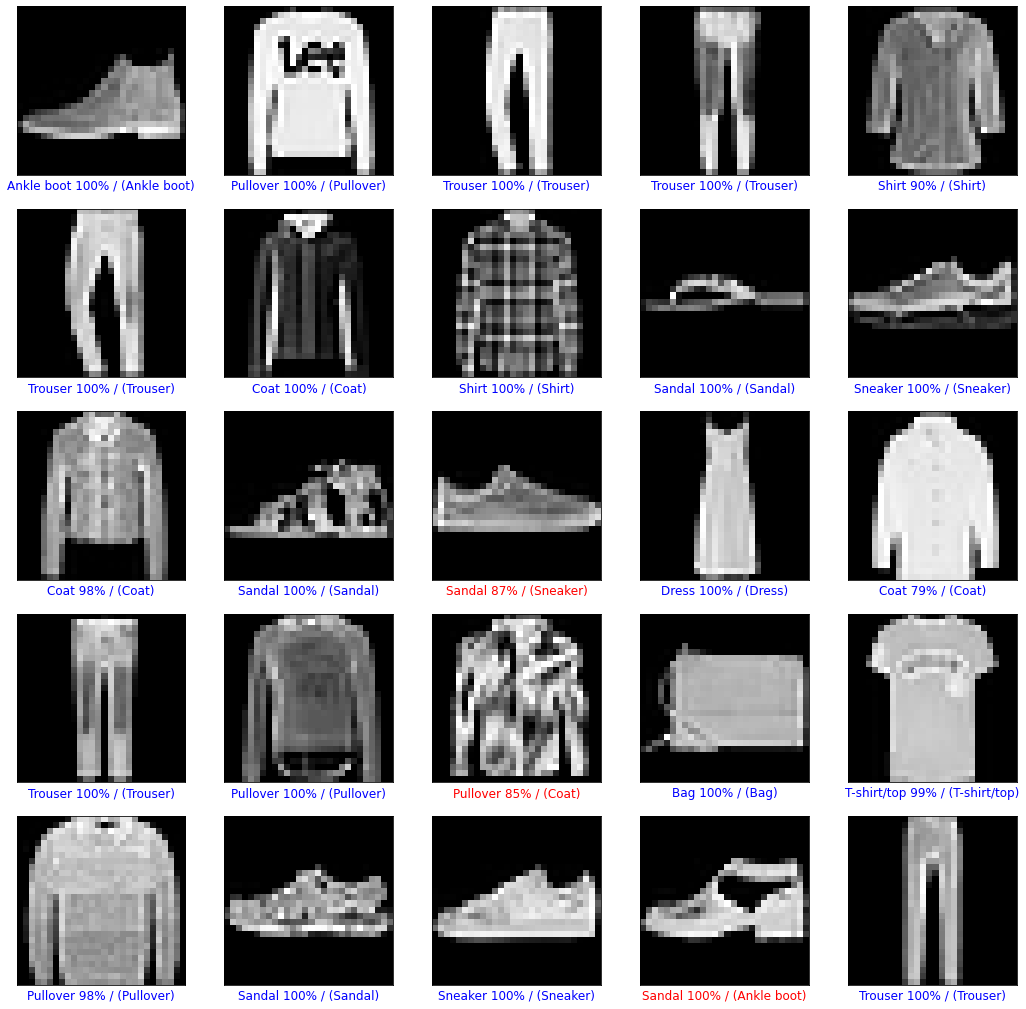

In [14]:
nrows = 5
ncols = 5
nimages = nrows * ncols

plt.figure(figsize=(18, 18))
for i in range(nimages):
  plt.subplot(nrows, ncols, i+1)
  plot_image(i)